In [1]:
#quickstart
from pathlib import Path
import pandas as pd
from bids import BIDSLayout
from joblib import Parallel, delayed
import nilearn
import nibabel as nib
import nltools.prefs as prf
from nilearn import datasets, image, plotting, input_data
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, index_img
import numpy as np
import matplotlib.pylab as plt

import rpy2
from rpy2.robjects.packages import importr
from pymer4 import Lmer
psych = importr('psych')


import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

import os
import glob
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from nltools.stats import fdr, one_sample_permutation
from copy import deepcopy
from nltools.utils import get_anatomical
import nltools.plotting as nlplt
from datetime import date
from joblib import Parallel, delayed

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from nilearn.input_data import NiftiMapsMasker,NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

import sys
import pandas as pd
import rpy2
from rpy2.robjects.packages import importr
from pymer4 import Lmer
psych = importr('psych')
import numpy as np

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

import os
import glob
import seaborn as sns
from statistics import mean
import matplotlib.style as style

#dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/dat_paths_11272019.csv') 
#atlas = image.load_img('/data/MBDU/midla/notebooks/campcc/hox_msdl_atlas.nii.gz')
#sub1 = image.load_img('/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmrip

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [1]:
dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/merged_paths_for_icc.csv',index_col=0)


NameError: name 'pd' is not defined

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/nilearn/plotting/displays.py:98: UserWarning: No contour levels were found within the data range.
  **kwargs)


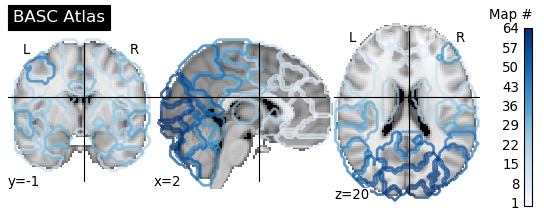

In [27]:
# style.use('classic')
# plotting.plot_prob_atlas(sorted_4d_img, view_type='contours',cmap = 'Blues',colorbar=True, dim= 0,alpha=.7,title='BASC Atlas')

In [20]:
# sorted_4d_img.to_filename('/data/MBDU/midla/notebooks/campcc/test_retest/basc_atlas.nii.gz')

In [437]:
sorted_4d_img = image.load_img('/data/MBDU/midla/notebooks/campcc/test_retest/basc_atlas.nii.gz')

In [438]:
sorted_4d_img.shape

(53, 64, 52, 64)

In [ ]:
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')
basc64 = basc['scale064']
atlas = image.load_img(basc64)
atlas_dat = atlas.get_fdata()
uvs = np.unique(atlas_dat)
atlas_in_4d = []
for uv in uvs:
    atlas_in_4d.append((atlas_dat == uv).astype(int))
atlas_4d_dat = np.array(atlas_in_4d)
atlas_dfs = []
for ii, aa in enumerate(atlas_in_4d):
    row = {}
    row['orig_ind'] = ii
    row['x_min'], row['y_min'], row['z_min'] = np.array(np.where(aa)).min(1)
    row['x_max'], row['y_max'], row['z_max'] = np.array(np.where(aa)).max(1)
    row['x_mean'], row['y_mean'], row['z_mean'] = np.array(np.where(aa)).mean(1)
    atlas_dfs.append(row)
atlas_dfs = pd.DataFrame(atlas_dfs)
atlas_df = atlas_dfs.sort_values('y_min', ascending=False).reset_index(drop=True).reset_index().rename(columns={'index':'new_index'})
atlas_df['match_ind'] = atlas_df.orig_ind + 1000
atlas_df['new_index'] +=1
atlas_df.loc[atlas_df['match_ind'] == 1000, 'new_index']=0
sorted_dat = atlas_dat + 1000
for ii, row in atlas_df.iterrows():
    sorted_dat[sorted_dat == row.match_ind] = row.new_index
sorted_atlas = image.new_img_like(atlas, sorted_dat, atlas.affine, atlas.header)
uvs = np.unique(sorted_dat)
atlas_in_4d = np.zeros(list(atlas.shape) + [len(uvs)-1], dtype=int)
for ii, uv in enumerate(uvs):
    if uv != 0:
        atlas_in_4d[:,:,:,ii-1] = (sorted_dat == uv).astype(int)
sorted_4d_img = image.new_img_like(atlas,atlas_in_4d, affine=atlas.affine,copy_header=True)


row = dat_paths.iloc[0]
    
img = image.load_img(row.scaled_path_x)
regions_extracted_img = resample_to_img(sorted_4d_img,img,interpolation='nearest')

In [439]:
row = dat_paths.iloc[0]
    
img = image.load_img(row.scaled_path_x)
regions_extracted_img = resample_to_img(sorted_4d_img,img,interpolation='nearest')

In [440]:
regions_extracted_img.to_filename('/data/MBDU/midla/notebooks/campcc/basc_atlas_resampled_near.nii.gz')

In [31]:
#Function: takes in row and masker object
#Returns image masked by grey matter, confounds, and transformed to atlas masker
def gm_weight_and_mask_task(row, regions_extracted_img, metric,cfd_type,n_dummy=4, min_trs=100,**kwargs):
    img = image.load_img(row.scaled_path_x)
    if img.get_fdata().shape[-1] < min_trs:
        return None
    # load subjects grey matter mask
    mask_img = resample_to_img(image.load_img(row.mask_path_x),img)
    mask_dat = mask_img.get_fdata()[:,:,:,np.newaxis]

    # make a binary grey matter mask
    mask_bin = mask_dat > 0

    # mask the regions image by the subject grey matter
    regions_masked_dat = regions_extracted_img.get_fdata() * mask_bin
    regions_masked_img = image.new_img_like(regions_extracted_img, 
                                            regions_masked_dat, 
                                            affine=regions_extracted_img.affine, 
                                            copy_header=True)

    # create a new masker instance
    masker = input_data.NiftiMapsMasker(
        regions_masked_img, resampling_target="data", **kwargs)

    #apply the grey matter mask to the image data
    gm_dat = mask_dat * img.get_fdata()
    gm_img = image.new_img_like(img, gm_dat, affine=img.affine, copy_header=True)

    cfd = pd.read_csv(row.cfds_physio_path_x, sep='\t',index_col=0)
    cols = [cc for cc in cfd.columns if 'censor' in cc]
    cols.extend([cc for cc in cfd.columns if 'cosine' in cc])
    if cfd_type != 'cc':
        cols.extend([cc for cc in cfd.columns if 'trans' in cc])
        cols.extend([cc for cc in cfd.columns if 'rot' in cc])
    if cfd_type == 'ccmp' or cfd_type == 'ccmpt':
        cols.extend([cc for cc in cfd.columns if 's0.' in cc])
    if cfd_type == 'ccmt' or cfd_type == 'ccmpt':
        cols.extend([cc for cc in cfd.columns if 'comp_cor' in cc])
    if metric == 'ifc':
        cfds= cfd.loc[:, cols]
    else:
        cols.extend([cc for cc in cfd.columns[:8].values])
        cfds = cfd.loc[:, cols]
    if gm_img.get_fdata().shape[-1] > 362:
        gm_img = image.index_img(gm_img,slice(0,362))

    resdir = '/data/MBDU/midla/notebooks/campcc/subject_ts/'
    #print(f'{resdir}basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_{metric}_cfds_{cfd_type}.csv')
    pd.DataFrame(masker.fit_transform(gm_img,cfds[:-4].values)[n_dummy:,:]).to_csv(f'{resdir}basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_{metric}_cfds_{cfd_type}.csv',header=None, index=None)


In [322]:
gm_img.shape

(97, 115, 97, 362)

In [323]:
cfds.shape

(366, 88)

In [325]:
Parallel(n_jobs=10, verbose=10)(delayed(gm_weight_and_mask_task)(row,regions_extracted_img,metric,cfd,t_r=2.0,detrend=False,
                                                                 low_pass=.1, high_pass=.01,memory='nilearn_cache', memory_level=1) for metric,cfd in y)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:  3.2min remaining:  7.4min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:  3.2min remaining:  3.2min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:  3.2min remaining:  1.4min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  3.3min finished


[None, None, None, None, None, None, None, None, None, None]

In [321]:
row

subject                                                                                                                                                                                                                       23757
session                                                                                                                                                                                                                           2
run                                                                                                                                                                                                                               1
task_x                                                                                                                                                                                                                          mid
confounds_path_x                                 /data/MBDU/midla/data/derivatives/fitli

In [14]:
Parallel(n_jobs=10, verbose=10)(delayed(gm_weight_and_mask_rest)(row,regions_extracted_img, t_r=2.5, detrend=False,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1) for _, row in dat_paths.iterrows())

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  5.6min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:  7.9min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  9.7min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed: 11.9min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed: 13.9min
[Parallel(n_jobs=10)]: Done  97 out of 105 | elapsed: 17.0min remaining:  1.4min
[Parallel(n_jobs=10)]: Done 105 out of 105 | elapsed: 18.1min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [8]:
tnames = []
for _,row in dat_paths.iterrows():
    if os.path.isfile('/data/MBDU/midla/notebooks/campcc/subject_ts/basc_ts_subject_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task_x)):
        tnames.append('/data/MBDU/midla/notebooks/campcc/subject_ts/basc_ts_subject_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task_x))
    else:
        print(f'task file missing at index {_}')
        tnames.append('')
    
dat_paths['task_ts_path'] = tnames
rnames = []
for _,row in dat_paths.iterrows():
    if os.path.isfile('/data/MBDU/midla/notebooks/campcc/subject_ts/basc_ts_subject_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task_y)):
        rnames.append('/data/MBDU/midla/notebooks/campcc/subject_ts/basc_ts_subject_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task_y))
    else:
        print(f'rest file missing at index {_}')
        rnames.append('')
    
dat_paths['rest_ts_path'] = rnames

In [270]:
def lr_ifc(confounds_path,time_series_path,cfd_type):
    if(time_series_path == ''):
        print(f'timeseries {time_series_path} missing')
        return None
    cfd = pd.read_csv(confounds_path,sep='\t',index_col=0)
    time_series = pd.read_csv(time_series_path,header=None).values
    cols = [cc for cc in cfd.columns if 'censor' in cc]
    cols.extend([cc for cc in cfd.columns if 'cosine' in cc])
    if cfd_type != 'cc':
        cols.extend([cc for cc in cfd.columns if 'trans' in cc])
        cols.extend([cc for cc in cfd.columns if 'rot' in cc])
    if cfd_type == 'ccmp' or cfd_type == 'ccmtp':
        cols.extend([cc for cc in cfd.columns if 's0.' in cc])
    if cfd_type == 'ccmt' or cfd_type == 'ccmtp':
        cols.extend([cc for cc in cfd.columns if 'comp_cor' in cc])
    censored_time_series = time_series.copy()
    for yi in range(time_series.shape[1]):
        X= cfd.loc[4:len(time_series)+3, cols[8:]]
        y = time_series[:,yi]
        lr = LinearRegression()
        fitted = lr.fit(X,y)
        pred = fitted.predict(X)
        censored_time_series[:,yi] = y-pred
        
#     correlation_measure = ConnectivityMeasure(kind='correlation')
#     correlation_matrices = correlation_measure.fit_transform([censored_time_series])
#     pd.DataFrame(correlation_matrices[0]).to_csv('/data/MBDU/midla/notebooks/campcc/test_retest/matrices_for_icc/ifc/cm_{}_session_{}_run_{}_task_{}_cfd_{}.csv'.format(row.subject,row.session,row.run,row.task_x,cfd_alph),header = None,index=None)
    return censored_time_series

def lr_bg(confounds_path,time_series_path,cfd_type):
    if(time_series_path == ''):
        print(f'timeseries {time_series_path} missing')
        return None
    cfd = pd.read_csv(confounds_path,sep='\t',index_col=0)
    time_series = pd.read_csv(time_series_path,header=None).values
    cols = [cc for cc in cfd.columns if 'censor' in cc]
    cols.extend([cc for cc in cfd.columns if 'cosine' in cc])
    if cfd_type != 'cc':
        cols.extend([cc for cc in cfd.columns if 'trans' in cc])
        cols.extend([cc for cc in cfd.columns if 'rot' in cc])
    if cfd_type == 'ccmp' or cfd_type == 'ccmtp':
        cols.extend([cc for cc in cfd.columns if 's0.' in cc])
    if cfd_type == 'ccmt' or cfd_type == 'ccmtp':
        cols.extend([cc for cc in cfd.columns if 'comp_cor' in cc])
    censored_time_series = time_series.copy()
    for yi in range(time_series.shape[1]):
        X= cfd.loc[4:len(time_series)+3, cols]
        y = time_series[:,yi]
        lr = LinearRegression()
        fitted = lr.fit(X,y)
        pred = fitted.predict(X)
        censored_time_series[:,yi] = y-pred
        
#     correlation_measure = ConnectivityMeasure(kind='correlation')
#     correlation_matrices = correlation_measure.fit_transform([censored_time_series])
#     pd.DataFrame(correlation_matrices[0]).to_csv('/data/MBDU/midla/notebooks/campcc/test_retest/matrices_for_icc/bgc/cm_{}_session_{}_run_{}_task_{}_cfd_{}.csv'.format(row.subject,row.session,row.run,row.task_x,cfd_alph),header = None,index=None)
    return censored_time_series

def lr_rest(confounds_path,time_series_path,cfd_type):
    if(time_series_path == ''):
        print(f'timeseries {time_series_path} missing')
        return None
    cfd = pd.read_csv(confounds_path,sep='\t',index_col=0)
    time_series = pd.read_csv(time_series_path,header=None).values
    cols = [cc for cc in cfd.columns if 'censor' in cc]
    cols.extend([cc for cc in cfd.columns if 'cosine' in cc])
#     if cfd_type != 'cc':
#         cols.extend([cc for cc in cfd.columns if 'trans' in cc])
#         cols.extend([cc for cc in cfd.columns if 'rot' in cc])
    if cfd_type == 'ccmp' or cfd_type == 'ccmtp':
        cols.extend([cc for cc in cfd.columns if 's0.' in cc])
    if cfd_type == 'ccmt' or cfd_type == 'ccmtp':
        cols.extend([cc for cc in cfd.columns if 'comp_cor' in cc])
    censored_time_series = time_series.copy()
    for yi in range(time_series.shape[1]):
        X= cfd.loc[4:len(time_series)+3, cols]
        y = time_series[:,yi]
        lr = LinearRegression()
        fitted = lr.fit(X,y)
        pred = fitted.predict(X)
        censored_time_series[:,yi] = y-pred
    return censored_time_series

#     correlation_measure = ConnectivityMeasure(kind='correlation')
#     correlation_matrices = correlation_measure.fit_transform([censored_time_series])
#     plotting.plot_matrix(correlation_matrices[0])
#     pd.DataFrame(correlation_matrices[0]).to_csv('/data/MBDU/midla/notebooks/campcc/test_retest/matrices_for_icc/rs/cm_{}_session_{}_run_{}_task_{}_cfd_{}.csv'.format(row.subject,row.session,row.run,row.task_y,cfd_alph),header = None,index=None)


def lr_concat(row,cfd_type):
    ts = pd.read_csv(row.task_ts_path,header=None)
    rs = pd.read_csv(row.rest_ts_path,header=None)
    time_series = pd.concat([ts,rs],axis=0,join='inner',sort=False,ignore_index=True).values
    if cfd_type == 'none':
        return time_series
    cfd_ts = pd.read_csv(row.cfds_physio_path_x, sep='\t')
    cfd_rs = pd.read_csv(row.cfds_physio_path_y, sep='\t')
    cfd = pd.concat([cfd_ts.loc[4:len(ts)+3],cfd_rs.loc[4:len(rs)+3]],axis=0,ignore_index=True,join='inner',sort=False)
    cols = [cc for cc in cfd.columns if 'censor' in cc]
    cols.extend([cc for cc in cfd.columns if 'cosine' in cc])
    if cfd_type != 'cc':
        cols.extend([cc for cc in cfd.columns if 'trans' in cc])
        cols.extend([cc for cc in cfd.columns if 'rot' in cc])
    if cfd_type == 'ccmp' or cfd_type == 'ccmtp':
        cols.extend([cc for cc in cfd.columns if 's0.' in cc])
    if cfd_type == 'ccmt' or cfd_type == 'ccmtp':
        cols.extend([cc for cc in cfd.columns if 'comp_cor' in cc])
    censored_time_series = time_series.copy()
    for yi in range(time_series.shape[1]):
        X= cfd.loc[:, cols]
        y = time_series[:,yi]
        lr = LinearRegression()
        fitted = lr.fit(X,y)
        pred = fitted.predict(X)
        censored_time_series[:,yi] = y-pred
    return censored_time_series
#     pd.DataFrame(p).to_csv('/data/MBDU/midla/notebooks/campcc/ppi/pca/pca_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task),header = None, index = None)
#     correlation_measure = ConnectivityMeasure(kind='correlation')
#     correlation_matrices = correlation_measure.fit_transform([censored_time_series])
#     pd.DataFrame(correlation_matrices[0]).to_csv('/data/MBDU/midla/notebooks/campcc/test_retest/matrices_for_icc/concat/cm_{}_session_{}_run_{}_task_{}_cfd_{}.csv'.format(row.subject,row.session,row.run,row.task_x,cfd_alph),header = None,index=None)

In [330]:
def run_corr(metric,cfd,dat_paths):
    #dat_paths = pd.DataFrame(bs_col).rename(columns={bs_col.name:'subject'}).merge(dat_paths, how='left', on=['subject'])
    rs_ts = []
    if metric == ['ifc']:
        for _,row in dat_paths.iterrows():
            rs_ts.append(lr_ifc(row.cfds_physio_path_x,row.task_ts_path, cfd))
    elif metric == ['bgc']:
        for _,row in dat_paths.iterrows():
            rs_ts.append(lr_bg(row.cfds_physio_path_x,row.task_ts_path, cfd))
    elif metric == ['rs']:
        for _,row in dat_paths.iterrows():
            rs_ts.append(lr_rest(row.cfds_physio_path,row.rest_ts_path, cfd))
    else:
        for _,row in dat_paths.iterrows():
            rs_ts.append(lr_concat(row, cfd))
        
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrices = correlation_measure.fit_transform(rs_ts)
    pd.DataFrame(correlation_measure.mean_).to_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices/cm_{metric}_{cfd}.csv',header=None,index=None)
    return correlation_matrices

In [175]:
corr = run_corr('rs','ccmpt',dat_paths)

In [180]:
icc(corr,'ccmpt',dat_paths,'rs','/data/MBDU/midla/notebooks/campcc/test_retest/')

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

,type,ICC,F,df1,df2,p,lower bound,upper bound,measure
Single_random_raters,ICC2,0.492343,4.879337,31.0,93.0,1.496412e-09,0.252129,0.726620,1_0
Single_fixed_raters,ICC3,0.492343,4.879337,31.0,93.0,1.496412e-09,0.250804,0.727063,1_0
Single_random_raters,ICC2,0.442544,4.175459,31.0,93.0,4.891484e-08,0.201533,0.691216,2_0
Single_fixed_raters,ICC3,0.442544,4.175459,31.0,93.0,4.891484e-08,0.200261,0.691691,2_0
Single_random_raters,ICC2,0.467192,4.507393,31.0,93.0,9.219878e-09,0.226220,0.708988,2_1
Single_fixed_raters,ICC3,0.467192,4.507393,31.0,93.0,9.219878e-09,0.224920,0.709448,2_1
Single_random_raters,ICC2,0.298917,2.705455,31.0,93.0,1.247039e-04,0.070128,0.576752,3_0
Single_fixed_raters,ICC3,0.298917,2.705455,31.0,93.0,1.247039e-04,0.069105,0.577282,3_0
Single_random_raters,ICC2,0.331046,2.979480,31.0,93.0,2.771515e-05,0.097809,0.604107,3_1
Single_fixed_raters,ICC3,0.331046,2.979480,31.0,93.0,2.771515e-05,0.096720,0.604632,3_1


In [224]:
dat_paths_fast = dat_paths.drop(['confounds_path_x','image_path_x','scaled_path_x','mask_path_x','ts_path','alt_ts_path','alt_rs_path','confounds_path_y','image_path_y','mask_path_y','scaled_path_y'], axis = 1)

In [341]:
dat_paths.to_csv('/data/MBDU/midla/notebooks/campcc/merged_paths_for_icc.csv')

In [210]:
dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/merged_paths_for_icc_05012020_info.csv')

In [ ]:
bs_num = sys.argv[1]
    corr_output_dir = sys.argv[2]
    cfd_alph = sys.argv[3]
    dat_paths = sys.argv[4]
    metric = sys.argv[5]
    icc_output_dir = sys.argv[6]

In [ ]:
dat_path = sys.argv[1]
    atlas_path = sys.argv[2]
    row = sys.argv[3]
    metric = sys.argv[4]
    cfd_type = sys.argv[5]

In [3]:
regions_extracted_img = image.load_img('/data/MBDU/midla/notebooks/campcc/basc_atlas_resampled.nii.gz')

In [19]:
regions_masked_img.to_filename('/data/MBDU/midla/notebooks/campcc/subject_ts/regions_masked_img.nii.gz')

In [57]:
!ls -lt '/data/MBDU/midla/notebooks/campcc/subject_ts/'

total 101120
-rw-r----- 1 campcc campcc    460503 May  1 13:34 basc_ts_subject_23643_session_3_run_1_metric_bgc_cfds_ccmpt.csv
-rw-r----- 1 campcc campcc    469306 May  1 12:26 basc_ts_subject_23520_session_1_run_1_metric_bgc_cfds_ccmpt.csv
-rw-r----- 1 campcc campcc    468519 May  1 12:16 basc_ts_subject_23520_session_1_run_1_metric_bgc_cfds_cc.csv
-rw-r----- 1 campcc campcc    251970 May  1 12:04 basc_ts_subject_23520_session_1_run_1_metric_bcg_cfds_cc.csv
-rw-r----- 1 campcc campcc    253516 May  1 11:56 basc_ts_subject_23520_session_1_run_1_metric_bcg_cfds_ccmpt.csv
-rw-r----- 1 campcc campcc 101158989 May  1 11:26 regions_masked_img.nii.gz
-rw-r----- 1 campcc campcc    253779 May  1 10:54 basc_ts_subject_23520_session_1_run_1_metric_rs_cfds_ccmpt.csv


In [206]:
row = dat_paths.iloc[49]

In [208]:
#gm
! export PATH=/data/MBDU/midla/env/bin:$PATH; python ts_extract.py /data/MBDU/midla/notebooks/campcc/merged_paths_for_icc.csv /data/MBDU/midla/notebooks/campcc/basc_atlas_resampled.nii.gz 49 bgc cc

/data/MBDU/midla/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
bgc_ccmpt_49
Extracting task timeseries from row 49
Traceback (most recent call last):
  File "ts_extract.py", line 120, in <module>
    gm_weight_and_mask_task(row,regions_extracted_img,metric,cfd_type,t_r=2.0,detrend=False,low_pass=.1, high_pass=.01,memory='nilearn_cache', memory_level=1)
  File "ts_extract.py", line 58, in gm_weight_and_mask_task
    pd.DataFrame(masker.fit_transform(gm_img,cfds.values)[n_dummy:,:]).to_csv(f'{resdir}basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_{metric}_cfds_{cfd_type}.

In [210]:
img = image.load_img(row.scaled_path_x)
# if img.get_fdata().shape[-1] < min_trs:
#     return None
# # load subjects grey matter mask
# mask_img = resample_to_img(image.load_img(row.mask_path_x),img)
# mask_dat = mask_img.get_fdata()[:,:,:,np.newaxis]

# # make a binary grey matter mask
# mask_bin = mask_dat > 0

# # mask the regions image by the subject grey matter
# regions_masked_dat = regions_extracted_img.get_fdata() * mask_bin
# regions_masked_img = image.new_img_like(regions_extracted_img, 
#                                         regions_masked_dat, 
#                                         affine=regions_extracted_img.affine, 
#                                         copy_header=True)

# # create a new masker instance
# masker = input_data.NiftiMapsMasker(
#     regions_masked_img, resampling_target="data", **kwargs)

# #apply the grey matter mask to the image data
# gm_dat = mask_dat * img.get_fdata()
# gm_img = image.new_img_like(img, gm_dat, affine=img.affine, copy_header=True)

cfd = pd.read_csv(row.cfds_physio_path_x, sep='\t',index_col=0)
cols = [cc for cc in cfd.columns if 'censor' in cc]
cols.extend([cc for cc in cfd.columns if 'cosine' in cc])
if cfd_type != 'cc':
    cols.extend([cc for cc in cfd.columns if 'trans' in cc])
    cols.extend([cc for cc in cfd.columns if 'rot' in cc])
if cfd_type == 'ccmp' or cfd_type == 'ccmpt':
    cols.extend([cc for cc in cfd.columns if 's0.' in cc])
if cfd_type == 'ccmt' or cfd_type == 'ccmpt':
    cols.extend([cc for cc in cfd.columns if 'comp_cor' in cc])
if metric == 'ifc':
    cfds= cfd.loc[:, cols]
else:
    cols.extend([cc for cc in cfd.columns[:8].values])
    cfds = cfd.loc[:, cols]
resdir = '/data/MBDU/midla/notebooks/campcc/subject_ts/'
#print(f'{resdir}basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_{metric}_cfds_{cfd_type}.csv')
#pd.DataFrame(masker.fit_transform(gm_img,cfds.values)[n_dummy:,:]).to_csv(f'{resdir}basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_{metric}_cfds_{cfd_type}.csv',header=None, index=None)

In [235]:
image.index_img(img,slice(0,362))

In [215]:
cfds

,censor_000,censor_001,censor_002,censor_003,censor_004,censor_005,censor_006,censor_007,censor_008,censor_009,censor_010,censor_011,censor_012,censor_013,censor_014,censor_015,censor_016,censor_017,censor_018,censor_019,censor_020,censor_021,censor_022,censor_023,censor_024,censor_025,censor_026,censor_027,censor_028,cosine00,cosine01,cosine02,cosine03,cosine04,cosine05,cosine06,cosine07,cosine08,cosine09,trans_x,trans_x_derivative1,trans_x_power2,trans_x_derivative1_power2,trans_y,trans_y_derivative1,trans_y_power2,trans_y_derivative1_power2,trans_z,trans_z_derivative1,trans_z_derivative1_power2,trans_z_power2,rot_x,rot_x_derivative1,rot_x_derivative1_power2,rot_x_power2,rot_y,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,s0.RVT0,s0.RVT1,s0.RVT2,s0.RVT3,s0.RVT4,s0.Resp0,s0.Resp1,s0.Resp2,s0.Resp3,s0.Card0,s0.Card1,s0.Card2,s0.Card3,t_comp_cor_00,t_comp_cor_01,t_comp_cor_02,t_comp_cor_03,neutral_anticipation,neutral_feedback,loss_anticipation,loss_feedback,gain_anticipation,gain_feedback,missed_gain_feedback,avoided_loss_feedback
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.902900e-09,0.000000,3.621028e-18,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,-5.162010e-09,0.000000,0.000000e+00,2.664635e-17,0.000000,0.000000,0.000000e+00,0.000000,-0.000061,0.000000,3.665079e-09,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,760.4812,1999.1132,1371.0561,475.9208,1001.1944,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.450290e-02,-0.044503,1.980508e-03,1.980508e-03,0.003892,0.003892,0.000015,1.514385e-05,4.934140e-01,0.493414,2.434574e-01,2.434574e-01,0.003467,0.003467,1.201884e-05,0.000012,0.001701,0.001762,2.893707e-06,3.103340e-06,-0.001776,-0.001776,3.154389e-06,3.154389e-06,651.2867,2263.2065,482.2626,728.4535,1138.0444,0.7320,-0.6813,-0.9974,-0.0717,0.0000,1.0000,0.0000,1.0000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.728930e-02,-0.002786,2.236278e-03,7.764025e-06,-0.011959,-0.015850,0.000143,2.512355e-04,5.097610e-01,0.016347,2.672244e-04,2.598563e-01,0.002982,-0.000484,2.347402e-07,0.000009,0.002556,0.000855,6.534823e-06,7.314355e-07,-0.002268,-0.000492,5.144096e-06,2.420640e-07,2042.9434,1717.3160,473.9433,920.5317,917.3880,-0.0015,-1.0000,0.0031,1.0000,0.7357,-0.6773,-0.9966,-0.0826,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.743710e-02,-0.000148,2.250278e-03,2.184484e-08,-0.004364,0.007595,0.000019,5.768797e-05,5.779040e-01,0.068143,4.643468e-03,3.339730e-01,0.003364,0.000382,1.458705e-07,0.000011,0.002297,-0.000260,5.273958e-06,6.750643e-08,-0.002372,-0.000104,5.625672e-06,1.077236e-08,2085.2616,929.7759,741.4190,1004.8815,684.8920,-0.0880,0.9961,-0.1754,0.9845,0.9452,0.3266,0.6174,-0.7866,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.0

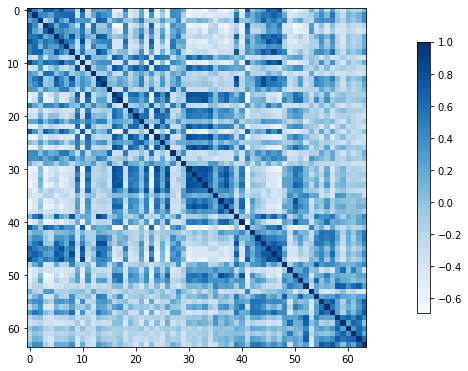

In [333]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform([pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices/bgc_cm_boot_01000_cfd_ccmpt.csv',header=None).values])
plotting.plot_matrix(correlation_matrices[0],cmap='Blues')

In [7]:
cfd_dict = {0:'cc',
           1:'ccm',
           2:'ccmp',
           3:'ccmt',
           4:'ccmpt'}

In [270]:
row=dat_paths.iloc[49]

In [2]:
! export PATH=/data/MBDU/midla/env/bin:$PATH; python ts_extract.py /data/MBDU/midla/notebooks/campcc/merged_paths_for_icc.csv /data/MBDU/midla/notebooks/campcc/basc_atlas_resampled.nii.gz 104 rs ccmpt

/data/MBDU/midla/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
rs_ccmpt_104
Extracting rest timeseries from row 104
/usr/bin/sh: line 1: 38023 Bus error               python ts_extract.py /data/MBDU/midla/notebooks/campcc/merged_paths_for_icc.csv /data/MBDU/midla/notebooks/campcc/basc_atlas_resampled.nii.gz 104 rs ccmpt


In [40]:
cmd_list = []
atlas = '/data/MBDU/midla/notebooks/campcc/basc_atlas_resampled.nii.gz'
dat_dir = '/data/MBDU/midla/notebooks/campcc/merged_paths_for_icc.csv'
regions_extracted_img = image.load_img(atlas)
for i in ['rs']:
    for j in cfd_dict:
        cfd = cfd_dict[j]
        for _,row in dat_paths.iterrows():
            boo = pd.read_csv(row.cfds_physio_path_y,sep='\t',index_col=0).isnull().values.any()
            if boo:
                print(f'{boo} {_} ')
            cmd_list.append(f'! export PATH=/data/MBDU/midla/env/bin:$PATH; python ts_extract.py {dat_dir} {atlas} {_} {i} {cfd}')

True 93 
True 93 
True 93 
True 93 
True 93 


In [46]:
image.load_img(dat_paths.loc[93].scaled_path_y).shape

(97, 115, 97, 196)

In [49]:
pd.read_csv(dat_paths.loc[93].cfds_physio_path_y,sep='\t',index_col=0)[:-5].shape

(196, 74)

In [34]:
print(f'{} {_} ')

False

In [8]:
cmd_list_concat_ifc = []
corr_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices'
dat_dir = '/data/MBDU/midla/notebooks/campcc/merged_paths_for_icc.csv'
output_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/bootstraps'
ts_dir = '/data/MBDU/midla/notebooks/campcc/subject_ts'
for i in ['concat_ifc']:
    for j in cfd_dict:
        cfd = cfd_dict[j]
        for k in range(0,1001):
            cmd_list_concat_ifc.append(f'! export PATH=/data/MBDU/midla/env/bin:$PATH; python /data/MBDU/midla/notebooks/campcc/run_bootstrap.py {k} {corr_dir} {cfd} {dat_dir} {ts_dir} {i} {output_dir}')

In [10]:
len(cmd_list_concat_ifc)

5005

In [9]:
cmds = '\n'.join(cmd_list_concat_ifc)

from pathlib import Path
swarm_file = Path('/data/MBDU/midla/notebooks/campcc/swarms/icc_swarm_concat_ifc.txt')
swarm_file.write_text(cmds)

run_name = 'icc_concat_ifc'
swarm_log_dir = '/data/MBDU/midla/notebooks/campcc/swarms/logs'

In [50]:
swarm_file

PosixPath('/data/MBDU/midla/notebooks/campcc/swarms/ts_swarm_rs.txt')

In [62]:
! swarm -f $swarm_file -g 25 -t 2 -b 15 --time 0:16:00 --logdir $swarm_log_dir --partition=quick --job-name $run_name

57464861


In [11]:
! swarm -f $swarm_file -g 5 -t 2 -b 48 --time 0:05:00 --logdir $swarm_log_dir --partition=quick --job-name $run_name

57931246


In [72]:
! export PATH=/data/MBDU/midla/env/bin:$PATH; python run_bootstrap.py 297 /data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices ccmp /data/MBDU/midla/notebooks/campcc/merged_paths_for_icc.csv /data/MBDU/midla/notebooks/campcc/subject_ts rs /data/MBDU/midla/notebooks/campcc/test_retest/bootstraps

/data/MBDU/midla/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
run_bootstrap.py:161: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (corr_matrices != []):
run_bootstrap.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dat_paths['unique_subject'][_] = row.unique_subject+10000
R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singula

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

In [5]:
! export PATH=/data/MBDU/midla/env/bin:$PATH; python run_bootstrap.py 296 /data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices ccmp /data/MBDU/midla/notebooks/campcc/merged_paths_for_icc.csv /data/MBDU/midla/notebooks/campcc/subject_ts concat_ifc /data/MBDU/midla/notebooks/campcc/test_retest/bootstraps

/data/MBDU/midla/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
testing


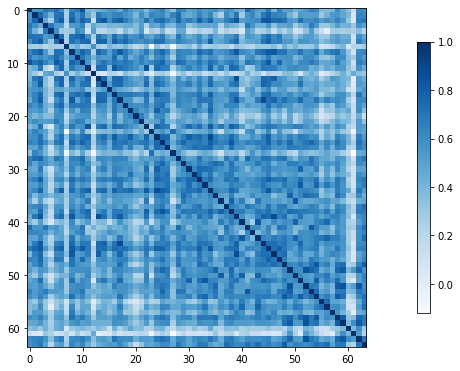

In [60]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform([pd.read_csv('/data/MBDU/midla/notebooks/campcc/subject_ts/basc_ts_subject_22409_session_2_run_1_metric_rs_cfds_cc.csv',header=None).values])
plotting.plot_matrix(correlation_matrices[0],cmap='Blues')

In [57]:
cfd = pd.read_csv(row.cfds_physio_path_y, sep='\t',index_col=0)
cols = [cc for cc in cfd.columns if 'censor' in cc]
cols.extend([cc for cc in cfd.columns if 'cosine' in cc])

cfds= cfd.loc[:, cols]
resdir = '/data/MBDU/midla/notebooks/campcc/subject_ts/'
#print(f'{resdir}basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_{metric}_cfds_{cfd_type}.csv')
boo = cfd.isnull().values.any()
cutoff = len(cfds)
if boo:
    cutoff = -5
cfds.values[:cutoff].shape

(196, 10)

In [247]:
cfd = 'cc'
metric = 'ifc'

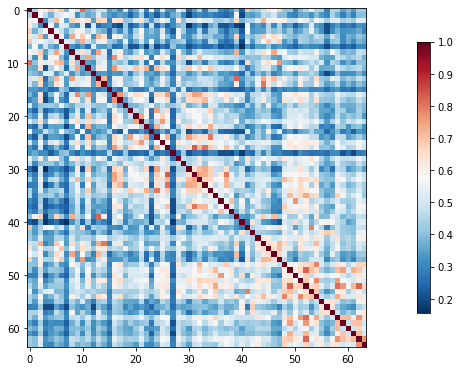

In [248]:
ts_dir = '/data/MBDU/midla/notebooks/campcc/subject_ts'
corr_output_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices'
bs_col = 1

rs_ts = []
#     if metric == ['ifc']:
#         for _,row in dat_paths.iterrows():
#             rs_ts.append(lr_ifc(row.cfds_physio_path_x,row.task_ts_path, cfd))
#     elif metric == ['bgc']:
#         for _,row in dat_paths.iterrows():
#             rs_ts.append(lr_bg(row.cfds_physio_path_x,row.task_ts_path, cfd))
#     elif metric == ['rs']:
#         for _,row in dat_paths.iterrows():
#             rs_ts.append(lr_rest(row.cfds_physio_path_y,row.rest_ts_path, cfd))
#     else:
#         for _,row in dat_paths.iterrows():
#             rs_ts.append(lr_concat(row, cfd))
for _,row in dat_paths.iterrows():
    if _ == 49:
        continue
    else:
        fname = f'{ts_dir}/basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_{metric}_cfds_{cfd}.csv'
        rs_ts.append(pd.read_csv(fname).values)
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(rs_ts)
plotting.plot_matrix(correlation_measure.mean_)
pd.DataFrame(correlation_measure.mean_).to_csv(f'{corr_output_dir}/{metric}_cm_{bs_col}_cfd_{cfd}.csv',header=None,index=None)
#return correlation_matrices

In [ ]:
bs_num = sys.argv[1]
    corr_output_dir = sys.argv[2]
    cfd_alph = sys.argv[3]
    dat_paths = sys.argv[4]
    ts_dir = sys.argv[5]
    metric = sys.argv[6]
    icc_output_dir = sys.argv[7]

In [255]:
dat_paths

,subject,session,run,task_x,confounds_path_x,image_path_x,scaled_path_x,mask_path_x,ts_path,alt_ts_path,alt_rs_path,cfds_physio_path_x,confounds_path_y,image_path_y,mask_path_y,scaled_path_y,task_y,cfds_physio_path_y,task_ts_path,rest_ts_path
0,22409,1,1,mid,/data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-22409/ses-01/run-1/out/out/fitlins/sub-22409/ses-01/sub-22409_ses-01_task-mid_run-1_design.tsv,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-22409/out/fmriprep/sub-22409/ses-01/func/sub-22409_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-22409/out/fmriprep/sub-22409/ses-01/func/sub-22409_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-22409/out/fmriprep/sub-22409/anat/sub-22409_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz,/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_22409_session_1_run_1_task_mid.csv,/data/MBDU/midla/notebooks/campcc/alt_rs_conn/ts_subject_24204_session_1_run_1_task_mid.csv,/data/MBDU/midla/notebooks/campcc/alt_rs_conn/ts_subject_22409_session_1_run_1_task_mid.csv,/data/MBDU/midla/notebooks/campcc/physio/new_cfds_mid/new_cfds_mid_subject_22409_session_1_run_1_task_mid.tsv,/data/MBDU/midla/data/derivatives/fitlins/rest_dm_only/sub-22409/ses-01/run-1/out/out/fitlins/sub-22409/ses-01/sub-22409_ses-01_task-rest_run-1_design.tsv,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22409/out/fmriprep/sub-22409/ses-01/func/sub-22409_ses-01_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22409/out/fmriprep/sub-22409/anat/sub-22409_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22409/out/fmriprep/sub-22409/ses-01/func/sub-22409_ses-01_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz,rest,/data/MBDU/midla/notebooks/campcc/physio/new_cfds_rest/new_cfds_rest_subject_22409_session_1_run_1_task_rest.tsv,/data/MBDU/midla/notebooks/campcc/subject_ts/basc_ts_subject_22409_session_1_run_1_task_mid.csv,/data/MBDU/midla/notebooks/campcc/subject_ts/basc_ts_subject_22409_session_1_run_1_task_rest.csv
1,22409,2,1,mid,/data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-22409/ses-02/run-1/out/out/fitlins/sub-22409/ses-02/sub-22409_ses-02_task-mid_run-1_design.tsv,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-22409/out/fmriprep/sub-22409/ses-02/func/sub-22409_ses-02_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-22409/out/fmriprep/sub-22409/ses-02/func/sub-22409_ses-02_task-mid_run-1_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-22409/out/fmriprep/sub-22409/anat/sub-22409_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz,/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_22409_session_2_run_1_task_mid.csv,/data/MBDU/midla/notebooks/campcc/alt_rs_conn/ts_subject_24204_session_1_run_1_task_mid.csv,/data/MBDU/midla/notebooks/campcc/alt_rs_conn/ts_subject_22409_session_2_run_1_task_mid.csv,/data/MBDU/midla/notebooks/campcc/physio/new_cfds_mid/new_cfds_mid_subject_22409_session_2_run_1_task_mid.tsv,/data/MBDU/midla/data/derivatives/fitlins/rest_dm_only/sub-22409/ses-02/run-1/out/out/fitlins/sub-22409/ses-02/sub-22409_ses-02_task-rest_run-1_design.tsv,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22409/out/fmriprep/sub-22409/ses-02/func/sub-22409_ses-02_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22409/out/fmriprep/sub-2

In [41]:
def run_corr(metric,cfd,dat_paths,ts_dir,corr_output_dir,icc_output_dir,bs_col):
    if not os.path.isfile(f'{icc_output_dir}/rs_icc_{bs_col.name}_cfd_{cfd_alph}.csv'):
        rs_ts = []
    #     if metric == ['ifc']:
    #         for _,row in dat_paths.iterrows():
    #             rs_ts.append(lr_ifc(row.cfds_physio_path_x,row.task_ts_path, cfd))
    #     elif metric == ['bgc']:
    #         for _,row in dat_paths.iterrows():
    #             rs_ts.append(lr_bg(row.cfds_physio_path_x,row.task_ts_path, cfd))
    #     elif metric == ['rs']:
    #         for _,row in dat_paths.iterrows():
    #             rs_ts.append(lr_rest(row.cfds_physio_path_y,row.rest_ts_path, cfd))
    #     else:
    #         for _,row in dat_paths.iterrows():
    #             rs_ts.append(lr_concat(row, cfd))
        for _,row in dat_paths.iterrows():
            fname = f'{ts_dir}/basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_{metric}_cfds_{cfd}.csv'
            rs_ts.append(pd.read_csv(fname).values)
        correlation_measure = ConnectivityMeasure(kind='correlation')
        correlation_matrices = correlation_measure.fit_transform(rs_ts)
        pd.DataFrame(correlation_measure.mean_).to_csv(f'{corr_output_dir}/{metric}_cm_{bs_col.name}_cfd_{cfd}.csv',header=None,index=None)
        return correlation_matrices
    else:
        if metric == 'concat':
            rs_ts = []
            for _,row in dat_paths.iterrows():
                rs_file = f'{ts_dir}/basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_rs_cfds_{cfd}.csv'
                bg_file = f'{ts_dir}/basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_bgc_cfds_{cfd}.csv'
                rs_ts.append(pd.read_csv(rs_file,header=None).append(pd.read_csv(bg_file,header=None),sort=False,ignore_index=True).values)
            correlation_measure = ConnectivityMeasure(kind='correlation')
            correlation_matrices = correlation_measure.fit_transform(rs_ts)
            csv = f'{corr_output_dir}/{metric}_cm_{bs_col.name}_cfd_{cfd}.csv'
            pd.DataFrame(correlation_measure.mean_).to_csv(csv,header=None,index=None)

            return correlation_matrices
    return []

In [42]:
bs_num = 0
corr_output_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices'
cfd_alph = 'cc'
dat_paths = '/data/MBDU/midla/notebooks/campcc/merged_paths_for_icc.csv'
ts_dir = '/data/MBDU/midla/notebooks/campcc/subject_ts'
metric = 'concat'
icc_output_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/bootstraps'

boots = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/bootstrap.csv')
bs_col = boots.loc[:, f'boot_{int(bs_num):05d}']

dat_paths = pd.read_csv(dat_paths)
dat_paths = pd.DataFrame(bs_col).rename(columns={bs_col.name:'subject'}).merge(dat_paths, how='left', on=['subject'])
corr = run_corr(metric,cfd_alph,dat_paths,ts_dir,corr_output_dir,icc_output_dir,bs_col)

In [37]:
corr.shape

(1, 64, 64)

In [30]:
if metric == 'concat':
    rs_ts = []
    for _,row in dat_paths.iterrows():
        rs_file = f'{ts_dir}/basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_rs_cfds_{cfd}.csv'
        bg_file = f'{ts_dir}/basc_ts_subject_{row.subject}_session_{row.session}_run_{row.run}_metric_bgc_cfds_{cfd}.csv'
        rs_ts.append(pd.read_csv(rs_file,header=None).append(pd.read_csv(bg_file,header=None),sort=False,ignore_index=True).values)
        correlation_measure = ConnectivityMeasure(kind='correlation')
        correlation_matrices = correlation_measure.fit_transform(rs_ts)
        csv = f'{corr_output_dir}/{metric}_cm_{bs_col.name}_cfd_{cfd}.csv'
        pd.DataFrame(correlation_measure.mean_).to_csv(csv,header=None,index=None)

In [40]:
correlation_matrices.shape

(105, 64, 64)

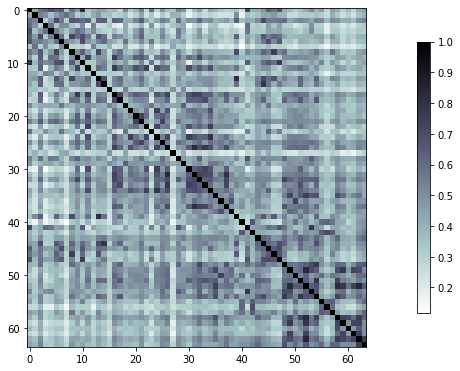

In [31]:
plotting.plot_matrix(correlation_measure.mean_,cmap='bone_r')

In [23]:
pd.read_csv(rs_file).values

array([[-3.58711266e-02, -6.71247719e-02, -2.18272063e-02, ...,
         2.88877307e-02, -3.60149206e-02, -1.18245245e-01],
       [-8.27823090e-02, -1.89078272e-01, -6.73369930e-02, ...,
        -7.93804229e-03, -1.03137170e-01, -3.75065951e-01],
       [ 1.46348135e-02, -5.95736395e-02,  4.72394432e-03, ...,
        -2.64870057e-02, -1.01127294e-01, -2.09568466e-01],
       ...,
       [ 7.99849251e-03, -1.13609799e-04,  3.84970736e-03, ...,
        -9.80718462e-03, -1.19014603e-02, -2.67032628e-02],
       [-3.68551148e-02,  4.82872640e-02,  1.67032124e-02, ...,
         5.77089393e-02,  6.12922763e-02,  3.04876529e-01],
       [-5.05849895e-02, -9.02048842e-02, -7.20221017e-02, ...,
        -4.79275715e-02, -1.14184257e-02, -3.79746040e-01]])